<a href="https://colab.research.google.com/github/kallooa/usefulScripts/blob/master/BambooHR_Data_Scientist_Candidate_Project_Aadi_Kalloo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BambooHR Data Scientist Candidate Project
## Predicting Customer Churn
### Author: Aadi Kalloo
2021-03-09

Data Source: https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data

The data used for this project was acquired from a challenge held by the ACM International Conference on Web Search and Data Mining (WSDM) in 2018. This challenge provided data from the music streaming service KKBox, a very popular Spotify-alternative in Taiwan. (https://www.kkbox.com/)

<br>

For my own convenience, this data was stored in Google Drive and can be accessed here: https://drive.google.com/drive/folders/1lkFWrMVJynpxvPF_jkA91XCunjRFc8oW?usp=sharing

<br>

### Why did I choose this dataset?
Relevance and similarity to the data at BambooHR:
*    This is real-world data from an existing and popular subscription-based company 
    *    Data provided in multiple grains
*    Included product usage data and transaction data

## Overview


1.   Introduction
    - Problem Overview
    - Project Goals
    - Libraries and Helper Functions
    - Import Data
    - Definitions of Features
2.   Data Cleaning & Preparation
    - Data Consolidation
    - Missing Values
3.   Feature Engineering
4.   Exploratory Data Analysis
    - Pair Plots
    - Customers
5.   Model Training & Evaluation
6.   Limitations & Future Directions
7.   Conclusions






## Introduction


### Problem Overview
<br>

KKBOX is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This business model is dependent on accurately predicting churn of their paid users as the cost of acquiring a new customer greatly exceeds the cost of retaining an existing customer.

<br>

### Significance
The key idea driving efforts in churn prediction:
![](https://drive.google.com/uc?export=view&id=17xynB1MQuwzfFE4UKJGROrtqY1nUHq7O)

<br>

### "Make new friends, but keep the old. One is silver, the other is gold."

<br>

### Project Goals
1.    Build a predictive model to identify members who will churn
    * Requirement: Best performing model must be better than both a random classifier and an "all-zeros" classifier (predicts 0 for all users)
2.    Identify primary drivers of churn
3.    Acquire a basic understanding of KKBox's customer base
4.    Gain insight into useful methods that can be applied to BambooHR's data to predict customer churn


### Libraries and Helper Functions

In [ ]:
#basic modules
from os import listdir
import warnings
import datetime

#data manipulation modules
import pandas as pd
import numpy as np

#statistics modules
from scipy.stats import jarque_bera, normaltest
import statsmodels.api as sm 

#machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, auc, f1_score, roc_auc_score, roc_curve, precision_score, accuracy_score, log_loss, confusion_matrix
import xgboost as xgb

#visualization
import seaborn as sns

#settings
%matplotlib inline
warnings.filterwarnings('ignore')

# organize evaluation metrics into dataframe
def eval_metrics(y_test, y_pred, name):
  return pd.DataFrame({
      'accuracy': accuracy_score(y_test, y_pred),
      'precision': precision_score(y_test, y_pred), 
      'recall': recall_score(y_test, y_pred), 
      'f1': f1_score(y_test, y_pred),
      'auc': roc_auc_score(y_test, y_pred),
      'log loss': log_loss(y_test, y_pred)
      }, 
      index=[name])

# plot confusion matrix with labels
def cm_plot(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

def adjusted_r2(log_reg, train):
  return (f"Adjusted R^2: {round(1 - (1 - log_reg.prsquared) * ((train.shape[0] - 1) / (train.shape[0] - train.shape[1] - 1)), 5)}")

### Import Data

How is the source data organized?

In [ ]:
data_dir = '/content/drive/MyDrive/bhr/data_scientist_sample_project/data/'
listdir(data_dir)

['transactions_v2.csv', 'user_logs_v2.csv', 'train_v2.csv', 'members_v3.csv']

Since there are only four files, it seems easiest to import manually and join into a single dataframe. We'll look at feature reduction and selection afterward.

In [ ]:
transactions  = pd.read_csv(f'{data_dir}/transactions_v2.csv')
product_usage = pd.read_csv(f'{data_dir}/user_logs_v2.csv')
churn_status  = pd.read_csv(f'{data_dir}/train_v2.csv')
members       = pd.read_csv(f'{data_dir}/members_v3.csv')

What do these dataframes contain?

In [ ]:
transactions.info(null_counts=True)
print('\n')
product_usage.info(null_counts=True)
print('\n')
members.info(null_counts=True)
print('\n')
churn_status.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   msno                    1431009 non-null  object
 1   payment_method_id       1431009 non-null  int64 
 2   payment_plan_days       1431009 non-null  int64 
 3   plan_list_price         1431009 non-null  int64 
 4   actual_amount_paid      1431009 non-null  int64 
 5   is_auto_renew           1431009 non-null  int64 
 6   transaction_date        1431009 non-null  int64 
 7   membership_expire_date  1431009 non-null  int64 
 8   is_cancel               1431009 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 98.3+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18396362 entries, 0 to 18396361
Data columns (total 9 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   msno        18396362 non-null  obj

Dataset is too large for Colab so take random sample of only 10% of total customers, stratified by is_churn to retain original class balance

In [ ]:
churn_status = churn_status.groupby('is_churn', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=0))

product_usage = product_usage.loc[product_usage.msno.isin(churn_status.msno)]
members = members.loc[members.msno.isin(churn_status.msno)]
transactions = transactions.loc[transactions.msno.isin(churn_status.msno)]

### Definitions of Features


#### transactions
transactions of users up until 2/28/2017.

- msno: user id
- payment_method_id: payment method
- payment_plan_days: length of membership plan in days
- plan_list_price: in New Taiwan Dollar (NTD)
- actual_amount_paid: in New Taiwan Dollar (NTD)
- is_auto_renew
- transaction_date: format %Y%m%d
- membership_expire_date: format %Y%m%d
- is_cancel: whether or not the user canceled the membership in this transaction.

#### product_usage
daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.

- msno: user id
- date: format %Y%m%d
- num_25: # of songs played less than 25% of the song length
- num_50: # of songs played between 25% to 50% of the song length
- num_75: # of songs played between 50% to 75% of of the song length
- num_985: # of songs played between 75% to 98.5% of the song length
- num_100: # of songs played over 98.5% of the song length
- num_unq: # of unique songs played
- total_secs: total seconds played

#### members
user information. Note that not every user in the dataset is available.

- msno
- city
- bd: age
- gender
- registered_via: registration method
- registration_init_time: format %Y%m%d
- expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

####churn_status
- msno: user id
- is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

### Grain


*   transactions = one day (time-series)
*   product_usage = one day (time-series)
*   churn_status = one customer
*   members = one customer

Goal: One dataframe is desired where one row = one customer


## Data Cleaning



### Data Consolidation

Looks like we can join on the `msno` variable, but is this a simple 1:1 join? Let's check for duplicate IDs (msno)

In [ ]:
[
  sum(product_usage.msno.duplicated()), 
  sum(churn_status.msno.duplicated()), 
  sum(members.msno.duplicated()), 
  sum(transactions.msno.duplicated())
]

[1274341, 0, 0, 19444]

For the sake of simplicity and time constraints, only a user's most recent transaction activity will be considered, but this area presents an excellent opportunity for next steps in this project. Both the `transactions` and `product_usage` dataframes will be 'flattened' to remove date/time as a feature, focus on aggregated customer lifetime metrics, and establish a common grain for all the dataframes.

In [ ]:
transactions_reduced = transactions.sort_values(by='transaction_date').drop_duplicates(subset=['msno'], keep='last')
num_transactions_df = pd.DataFrame(transactions.value_counts(subset='msno')).reset_index(drop=False)
num_transactions_df.columns= ['msno', 'num_transactions']
transactions_reduced = transactions_reduced.merge(num_transactions_df, on='msno', how='left')

In [ ]:
product_usage.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
5,qR/ndQ5B+1cY+c9ihwLoiz+RFiqEnGyQKo32ZErEVKo=,20170331,3,0,0,0,39,41,9786.842
10,Cwk7eMLB8Gn8WuzECC2i/GboGXOfkGhS8ju6Brrk2F8=,20170331,7,1,2,7,69,74,18169.176
15,NCRcE4eNurBdOoRk0m+hwDz94xBN6+KL5PTwen4hmWU=,20170325,40,6,2,2,131,149,29400.889
35,Dde9YoZqShj9wZAgEm0mc+V995QOExh+1WRlL9oMQJg=,20170318,34,13,7,6,83,74,24825.041
42,IYbqsaIlPpGu/an6G3YnpgAnwlJYp/90wBRGakRveUg=,20170319,0,0,0,0,203,32,38807.000


In [ ]:
product_usage_lifetime = product_usage.groupby(['msno']) \
                                      .aggregate({'num_unq': ['mean', 'std', 'sum'], 'total_secs': ['mean', 'std', 'sum']}) \
                                      .reset_index(drop=False)

product_usage_lifetime.columns = product_usage_lifetime.columns.map('_'.join).str.strip()
product_usage_lifetime.rename({'msno_': 'msno'}, inplace=True, axis=1)
product_usage_lifetime.head()

,msno,num_unq_mean,num_unq_std,num_unq_sum,total_secs_mean,total_secs_std,total_secs_sum
0,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,18.111111,13.806198,163,3532.032889,2904.624504,31788.296
1,++6xEqu4JANaRY4GjEfEFtLtqOvZvYPyP3uk/PW9Ces=,5.888889,4.702245,53,1060.149889,1160.396247,9541.349
2,++CITmZPtQDWOi01uceGb75QJblInDRhjjGM1MmsiSY=,24.666667,45.645007,148,2826.416333,4492.855329,16958.498
3,++M4G6SSlhINyHbCMt5KVjPdbDAZkaJ0a51FF8lGr04=,39.250000,35.006578,785,11010.629650,8571.240534,220212.593
4,++Tp41swlnwrt2eLTL1cSAn97YgfRVh3uG9VHEmAySA=,22.900000,15.249408,229,3619.380000,2586.232384,36193.800


Let's check again for duplicate IDs

In [ ]:
[
  sum(product_usage_lifetime.msno.duplicated()), 
  sum(churn_status.msno.duplicated()), 
  sum(members.msno.duplicated()), 
  sum(transactions_reduced.msno.duplicated())
]

[0, 0, 0, 0]

In [ ]:
df = churn_status.merge(members, on='msno', how='left') \
                 .merge(transactions_reduced, on='msno', how='left') \
                 .merge(product_usage_lifetime, on='msno', how='left')

In [ ]:
sum(df.msno.duplicated())

0

No duplicated IDs! I finally have a single dataframe. What does it look like?

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97096 entries, 0 to 97095
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    97096 non-null  object 
 1   is_churn                97096 non-null  int64  
 2   city                    86216 non-null  float64
 3   bd                      86216 non-null  float64
 4   gender                  39030 non-null  object 
 5   registered_via          86216 non-null  float64
 6   registration_init_time  86216 non-null  float64
 7   payment_method_id       93284 non-null  float64
 8   payment_plan_days       93284 non-null  float64
 9   plan_list_price         93284 non-null  float64
 10  actual_amount_paid      93284 non-null  float64
 11  is_auto_renew           93284 non-null  float64
 12  transaction_date        93284 non-null  float64
 13  membership_expire_date  93284 non-null  float64
 14  is_cancel               93284 non-null

Since I am not currently interested in examining registration and transaction dates, these variables will be dropped from the dataframe.

In [ ]:
df.drop(columns=['transaction_date', 'membership_expire_date', 'registration_init_time'], inplace=True)

df.head()

,msno,is_churn,city,bd,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_transactions,num_unq_mean,num_unq_std,num_unq_sum,total_secs_mean,total_secs_std,total_secs_sum
0,HswNTXYn4yqi+SBF/+CEXLFMsMY782zPuZrSbp9rnXU=,0,1.0,0.0,NaN,7.0,41.0,30.0,100.0,100.0,1.0,0.0,1.0,13.500000,6.595453,81.0,3257.179667,1573.402852,19543.078
1,YpV73qpyuBf0hE297bPrJC5ReGFAggVlRAhkdmkosXg=,0,1.0,0.0,NaN,7.0,41.0,30.0,149.0,149.0,1.0,0.0,1.0,48.840000,37.209631,1221.0,14311.786320,9877.770169,357794.658
2,5xMdelsM6lD/cjJV68fPwY204ex4/PMyhOp+cw1fuio=,0,5.0,23.0,male,9.0,38.0,30.0,149.0,149.0,0.0,0.0,1.0,51.193548,34.545062,1587.0,12388.903387,8911.757318,384056.005
3,yLy69CnA2ii5ASjdRmAdy3kxzm2vUQ5XlRPbvgIHLSg=,0,1.0,0.0,NaN,7.0,41.0,30.0,99.0,99.0,1.0,0.0,1.0,8.375000,5.976858,201.0,1965.923792,1604.436391,47182.171
4,xM2rRflI17cwH60+jpwDoWKzM+ng6zpMKVrLVfG06DQ=,0,1.0,0.0,NaN,7.0,41.0,30.0,99.0,99.0,1.0,0.0,1.0,14.315789,10.990160,272.0,2776.411526,2100.921241,52751.819


`gender` should be converted to a numeric variable

In [ ]:
df.gender[df.gender == 'male'] = 1.0
df.gender[df.gender == 'female'] = 2.0

df.gender = df.gender.astype(float)

`bd` actually represents age so I will rename then fill 0 for age values outside of the range 1-99. 

In [ ]:
df.rename({'bd': 'age'}, axis=1, inplace=True)

What does the data actually look like?

In [ ]:
df.describe()

,is_churn,city,age,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_transactions,num_unq_mean,num_unq_std,num_unq_sum,total_secs_mean,total_secs_std,total_secs_sum
count,97096.000000,86216.000000,86216.000000,39030.000000,86216.000000,93284.000000,93284.000000,93284.000000,93284.000000,93284.000000,93284.000000,93284.000000,75536.000000,72663.000000,75536.000000,75536.000000,72663.000000,7.553600e+04
mean,0.089942,5.934281,13.670595,1.471817,6.891447,38.883174,33.910242,145.227445,145.030509,0.911475,0.024613,1.208439,24.271119,18.006909,508.139841,6433.480671,4811.658591,1.383377e+05
std,0.286100,6.439823,21.183568,0.499211,1.931456,3.819127,33.356557,140.628189,140.712164,0.284059,0.154943,1.228270,19.913597,12.859262,588.238415,6310.667648,4207.509679,1.817050e+05
min,0.000000,1.000000,-50.000000,1.000000,3.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.914000,0.000000,9.140000e-01
25%,0.000000,1.000000,0.000000,1.000000,7.000000,38.000000,30.000000,99.000000,99.000000,1.000000,0.000000,1.000000,11.961538,9.311883,123.750000,2860.418272,2313.857313,3.010377e+04
50%,0.000000,1.000000,0.000000,1.000000,7.000000,41.000000,30.000000,149.000000,149.000000,1.000000,0.000000,1.000000,19.200000,15.279820,331.000000,4693.584321,3869.808260,8.196868e+04
75%,0.000000,13.000000,27.000000,2.000000,9.000000,41.000000,30.000000,149.000000,149.000000,1.000000,0.000000,1.000000,30.231410,23.578631,677.000000,7691.143187,6230.981971,1.741059e+05
max,1.000000,22.000000,1820.000000,2.000000,13.000000,41.000000,450.000000,1788.000000,1788.000000,1.000000,1.000000,89.000000,430.866667,303.084837,12926.000000,209181.397000,240304.367559,2.584174e+06


Age needs to be cleaned up. Will set all values outside of the range 1-99 to 0. Could also try to impute values with an algorithm like k-nearest neighbors.




In [ ]:
df.loc[(df.age < 1) | (df.age > 99), 'age'] = 0

How many unique values does each column contain?

In [ ]:
for col in df.columns:
  print(f"{col}: {len(df[col].unique())}")

msno: 97096
is_churn: 2
city: 22
age: 91
gender: 3
registered_via: 6
payment_method_id: 31
payment_plan_days: 24
plan_list_price: 33
actual_amount_paid: 33
is_auto_renew: 3
is_cancel: 3
num_transactions: 45
num_unq_mean: 16305
num_unq_std: 63709
num_unq_sum: 3283
total_secs_mean: 75505
total_secs_std: 72660
total_secs_sum: 75508


We can see a total of 4 variables that are binary: `is_churn` (our target variable), `gender`, `is_auto_renew`, and `is_cancel`. We can also see 3 categorical variables: `registered_via`, and `payment_method_id`, and `city` which we also know from the descriptions provided with the dataset

### Missing Values

In [ ]:
df.shape

(97096, 19)

Count of missing values per column:

In [ ]:
df.isnull().sum(axis = 0)

msno                      0
is_churn                  0
city                  10880
age                   10880
gender                58066
registered_via        10880
payment_method_id      3812
payment_plan_days      3812
plan_list_price        3812
actual_amount_paid     3812
is_auto_renew          3812
is_cancel              3812
num_transactions       3812
num_unq_mean          21560
num_unq_std           24433
num_unq_sum           21560
total_secs_mean       21560
total_secs_std        24433
total_secs_sum        21560
dtype: int64

Over half of the dataset is missing data for `gender`, but otherwise missing values don't seem to exceed 25% of the # of rows. Will fill NAs for `gender` with 0, but I predict that this feature will not be very important

Are there any rows that are missing a lot of data?

In [ ]:
sorted(df.isnull().sum(axis = 1).unique())

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 17]

Some rows are missing data for more than half of the available features. Since there are only 23 columns, I plan to remove any rows with 7 or more missing values.

In [ ]:
df['row_null_count'] = df.isnull().sum(axis = 1)
df = df[df['row_null_count'] < 7]

df.isnull().sum(axis = 0)

msno                      0
is_churn                  0
city                      2
age                       2
gender                38128
registered_via            2
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
is_cancel                 0
num_transactions          0
num_unq_mean           2228
num_unq_std            4878
num_unq_sum            2228
total_secs_mean        2228
total_secs_std         4878
total_secs_sum         2228
row_null_count            0
dtype: int64

`gender` still missing many values. Will fill these and other remaining NAs with 0

In [ ]:
df = df.fillna(0).drop(columns=['row_null_count']).reset_index(drop=True)

df.head()

,msno,is_churn,city,age,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_transactions,num_unq_mean,num_unq_std,num_unq_sum,total_secs_mean,total_secs_std,total_secs_sum
0,HswNTXYn4yqi+SBF/+CEXLFMsMY782zPuZrSbp9rnXU=,0,1.0,0.0,0.0,7.0,41.0,30.0,100.0,100.0,1.0,0.0,1.0,13.500000,6.595453,81.0,3257.179667,1573.402852,19543.078
1,YpV73qpyuBf0hE297bPrJC5ReGFAggVlRAhkdmkosXg=,0,1.0,0.0,0.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,1.0,48.840000,37.209631,1221.0,14311.786320,9877.770169,357794.658
2,5xMdelsM6lD/cjJV68fPwY204ex4/PMyhOp+cw1fuio=,0,5.0,23.0,1.0,9.0,38.0,30.0,149.0,149.0,0.0,0.0,1.0,51.193548,34.545062,1587.0,12388.903387,8911.757318,384056.005
3,yLy69CnA2ii5ASjdRmAdy3kxzm2vUQ5XlRPbvgIHLSg=,0,1.0,0.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,1.0,8.375000,5.976858,201.0,1965.923792,1604.436391,47182.171
4,xM2rRflI17cwH60+jpwDoWKzM+ng6zpMKVrLVfG06DQ=,0,1.0,0.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,1.0,14.315789,10.990160,272.0,2776.411526,2100.921241,52751.819


## Feature Engineering

I am interested in pursuing the relative factoring method for engineering new features from the product usage data. I am looking to match the grain of my existing data, where 1 row = 1 customer.

In [ ]:
product_usage = product_usage[product_usage.msno.isin(churn_status.msno)]
product_usage.sort_values(['msno', 'date']).head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
8341517,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,20170301,0,0,0,0,3,3,699.912
12786566,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,20170313,0,2,0,0,10,12,2897.194
14963805,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,20170314,4,2,2,0,10,17,2924.670
11823519,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,20170315,4,1,0,0,14,18,3674.457
15966305,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,20170316,1,2,1,0,5,8,1442.764


In [ ]:
product_usage.date = pd.to_datetime(product_usage.date, format='%Y%m%d')

print(product_usage.date.min(), product_usage.date.max())

2017-03-01 00:00:00 2017-03-31 00:00:00


Here I was wondering whether or not the data needs to be split on the time axis so that the test set does not end up with information it should not have

In [ ]:
product_usage_train = product_usage.loc[product_usage.date.lt('2017-03-21')]
product_usage_test  = product_usage.loc[product_usage.date.ge('2017-03-21')]

product_usage_train = product_usage_train.set_index(['date'])
product_usage_train.head()

,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
date,,,,,,,,
2017-03-18,Dde9YoZqShj9wZAgEm0mc+V995QOExh+1WRlL9oMQJg=,34,13,7,6,83,74,24825.041
2017-03-19,IYbqsaIlPpGu/an6G3YnpgAnwlJYp/90wBRGakRveUg=,0,0,0,0,203,32,38807.000
2017-03-10,5q47XHnBIXfWVTk00FFP19zhu5KG2fB7E2u5L+hBZR4=,13,0,2,4,140,78,33449.000
2017-03-11,M5ThBvN+ZnNew7bSSFfgkj1QcbENzsEg0DJJckJIyKQ=,0,0,0,1,147,111,32397.046
2017-03-10,k6eJ3xRzpnAkLsdWp4fFsiN7loavl/agmfrUdvFCJQI=,22,11,7,1,0,36,2344.100


In [ ]:
product_usage_train.shape

(873731, 8)

### Work in Progress

Colab will not run this command due to resource requirements, but I was interested in creating trend-based features for usage activity:

In [ ]:
"""

for periods in [1, 3]:
  for col in ['total_secs', 'num_unq']:
    product_usage[f'{col}_pct_change_{periods}'] = product_usage.sort_values(['msno', 'date']).groupby(['msno'])[col].pct_change(periods=periods)

product_usage['date_rank'] = product_usage.groupby(['msno'])['date'].rank(method='dense', ascending=False)

new_features = product_usage.loc[product_usage.date_rank.eq(1), ['msno', 'total_secs_pct_change_3', 'num_unq_pct_change_3', 'total_secs_pct_change_7', 'num_unq_pct_change_7']]


"""

### Feature Engineering Cont.

Create a few basic features from transaction data:

In [ ]:
df['discount_amount'] = df['plan_list_price'] - df['actual_amount_paid']
df['has_discount'] = df.discount_amount.apply(lambda x: 1 if x > 0 else 0)
df['daily_charge'] = df['actual_amount_paid'] / df['payment_plan_days']
df['autorenew_not_cancel'] = ((df.is_auto_renew == 1) == (df.is_cancel == 0)).astype(int)
df['notautorenew_cancel'] = ((df.is_auto_renew == 0) == (df.is_cancel == 1)).astype(int)

Review what the dataframe contains currently:

In [ ]:
df.head()

,msno,is_churn,city,age,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_transactions,num_unq_mean,num_unq_std,num_unq_sum,total_secs_mean,total_secs_std,total_secs_sum,discount_amount,has_discount,daily_charge,autorenew_not_cancel,notautorenew_cancel
0,HswNTXYn4yqi+SBF/+CEXLFMsMY782zPuZrSbp9rnXU=,0,1.0,0.0,0.0,7.0,41.0,30.0,100.0,100.0,1.0,0.0,1.0,13.500000,6.595453,81.0,3257.179667,1573.402852,19543.078,0.0,0,3.333333,1,1
1,YpV73qpyuBf0hE297bPrJC5ReGFAggVlRAhkdmkosXg=,0,1.0,0.0,0.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,1.0,48.840000,37.209631,1221.0,14311.786320,9877.770169,357794.658,0.0,0,4.966667,1,1
2,5xMdelsM6lD/cjJV68fPwY204ex4/PMyhOp+cw1fuio=,0,5.0,23.0,1.0,9.0,38.0,30.0,149.0,149.0,0.0,0.0,1.0,51.193548,34.545062,1587.0,12388.903387,8911.757318,384056.005,0.0,0,4.966667,0,0
3,yLy69CnA2ii5ASjdRmAdy3kxzm2vUQ5XlRPbvgIHLSg=,0,1.0,0.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,1.0,8.375000,5.976858,201.0,1965.923792,1604.436391,47182.171,0.0,0,3.300000,1,1
4,xM2rRflI17cwH60+jpwDoWKzM+ng6zpMKVrLVfG06DQ=,0,1.0,0.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,1.0,14.315789,10.990160,272.0,2776.411526,2100.921241,52751.819,0.0,0,3.300000,1,1


In [ ]:
df.describe()

,is_churn,city,age,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_transactions,num_unq_mean,num_unq_std,num_unq_sum,total_secs_mean,total_secs_std,total_secs_sum,discount_amount,has_discount,daily_charge,autorenew_not_cancel,notautorenew_cancel
count,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000,7.480600e+04,74806.000000,74806.000000,74806.000000,74806.000000,74806.000000
mean,0.064968,6.332366,14.668235,0.722054,6.926196,38.516322,34.860880,153.730623,153.510039,0.889875,0.021897,1.228979,23.662081,16.880063,501.152501,6276.579757,4512.706544,1.364975e+05,0.220584,0.002166,4.458261,0.867979,0.867979
std,0.246471,6.533175,16.315155,0.814980,1.965070,3.983224,37.159782,155.501808,155.598291,0.313047,0.146347,1.242308,20.075366,13.196203,589.309010,6323.907462,4254.770906,1.816722e+05,5.387887,0.046486,0.951246,0.338516,0.338516
min,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,7.000000,37.000000,30.000000,99.000000,99.000000,1.000000,0.000000,1.000000,11.363636,8.140723,113.000000,2718.817306,2019.350976,2.760006e+04,0.000000,0.000000,3.300000,1.000000,1.000000
50%,0.000000,4.000000,0.000000,0.000000,7.000000,40.000000,30.000000,149.000000,149.000000,1.000000,0.000000,1.000000,18.866667,14.475281,325.000000,4596.582008,3650.193280,8.034834e+04,0.000000,0.000000,4.966667,1.000000,1.000000
75%,0.000000,13.000000,28.000000,1.000000,9.000000,41.000000,30.000000,149.000000,149.000000,1.000000,0.000000,1.000000,29.833333,22.844100,672.000000,7582.879739,6022.431432,1.728790e+05,0.000000,0.000000,4.966667,1.000000,1.000000
max,1.000000,22.000000,99.000000,2.000000,13.000000,41.000000,450.000000,1788.000000,1788.000000,1.000000,1.000000,89.000000,430.866667,303.084837,12926.000000,209181.397000,240304.367559,2.584174e+06,180.000000,1.000000,6.000000,1.000000,1.000000


### Understanding the Independent Variables 
Are they normally distributed? Since sample size is sufficiently large, I will use the jarque-bera statistical test to check for normality.

In [ ]:
disc_vars = ['msno', 'registered_via', 'payment_method_id', 'gender', 'is_auto_renew', 'is_cancel', 'city', 'has_discount', 'autorenew_not_cancel', 'notautorenew_cancel']

cont_IVs = df.drop(columns=disc_vars)

for col in cont_IVs.columns:
  statistic, p_value = jarque_bera(cont_IVs[col]) #can also use sklearn normaltest
  normal = 'normal' if p_value > 0.05 else 'non-normal'
  print(f"{col}: Test Statistic = {statistic}, P-Value = {float(p_value)} -- {normal}")

is_churn: Test Statistic = 496503.16478250717, P-Value = 0.0 -- non-normal
age: Test Statistic = 6076.71472470747, P-Value = 0.0 -- non-normal
payment_plan_days: Test Statistic = 20667638.92801388, P-Value = 0.0 -- non-normal
plan_list_price: Test Statistic = 21759481.02185452, P-Value = 0.0 -- non-normal
actual_amount_paid: Test Statistic = 21675331.219045844, P-Value = 0.0 -- non-normal
num_transactions: Test Statistic = 1898688698.2203164, P-Value = 0.0 -- non-normal
num_unq_mean: Test Statistic = 751023.92007463, P-Value = 0.0 -- non-normal
num_unq_std: Test Statistic = 1226620.2726911488, P-Value = 0.0 -- non-normal
num_unq_sum: Test Statistic = 858288.4093453193, P-Value = 0.0 -- non-normal
total_secs_mean: Test Statistic = 3873072.92556142, P-Value = 0.0 -- non-normal
total_secs_std: Test Statistic = 371603213.5043848, P-Value = 0.0 -- non-normal
total_secs_sum: Test Statistic = 1372692.0078281828, P-Value = 0.0 -- non-normal
discount_amount: Test Statistic = 1773519606.3374841,

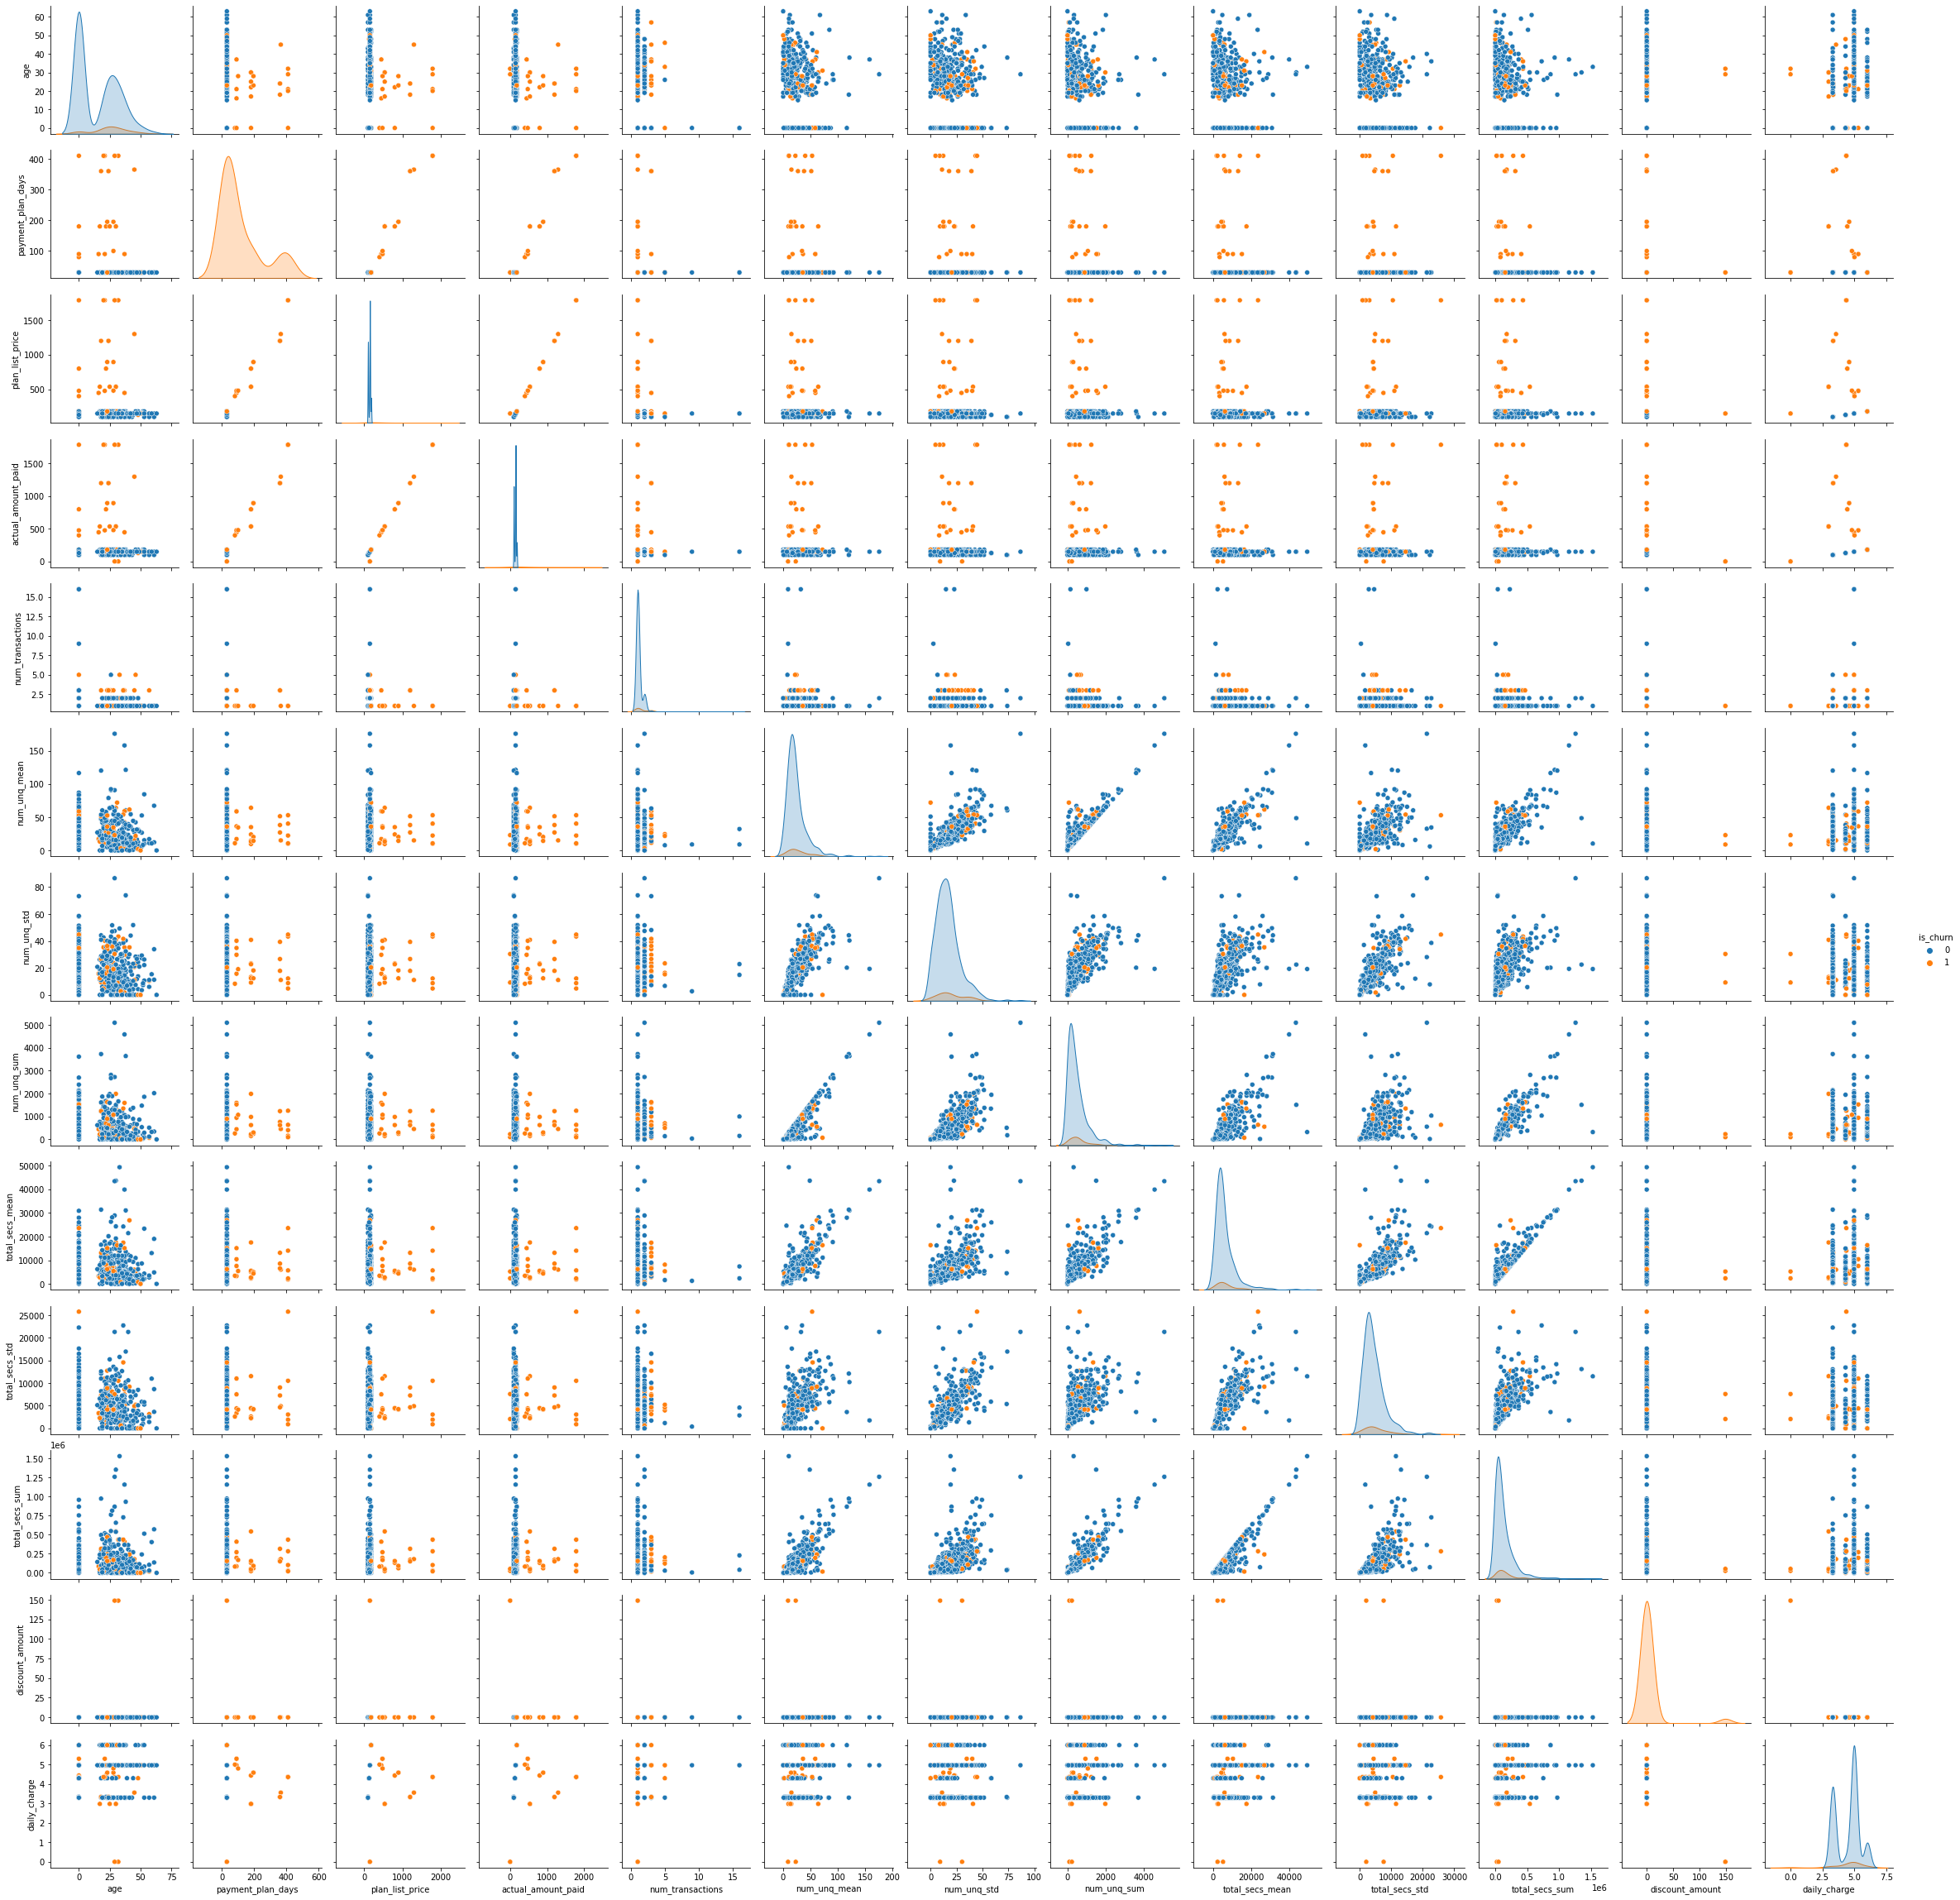

In [ ]:
sns.pairplot(cont_IVs.sample(frac=0.01), hue = 'is_churn')

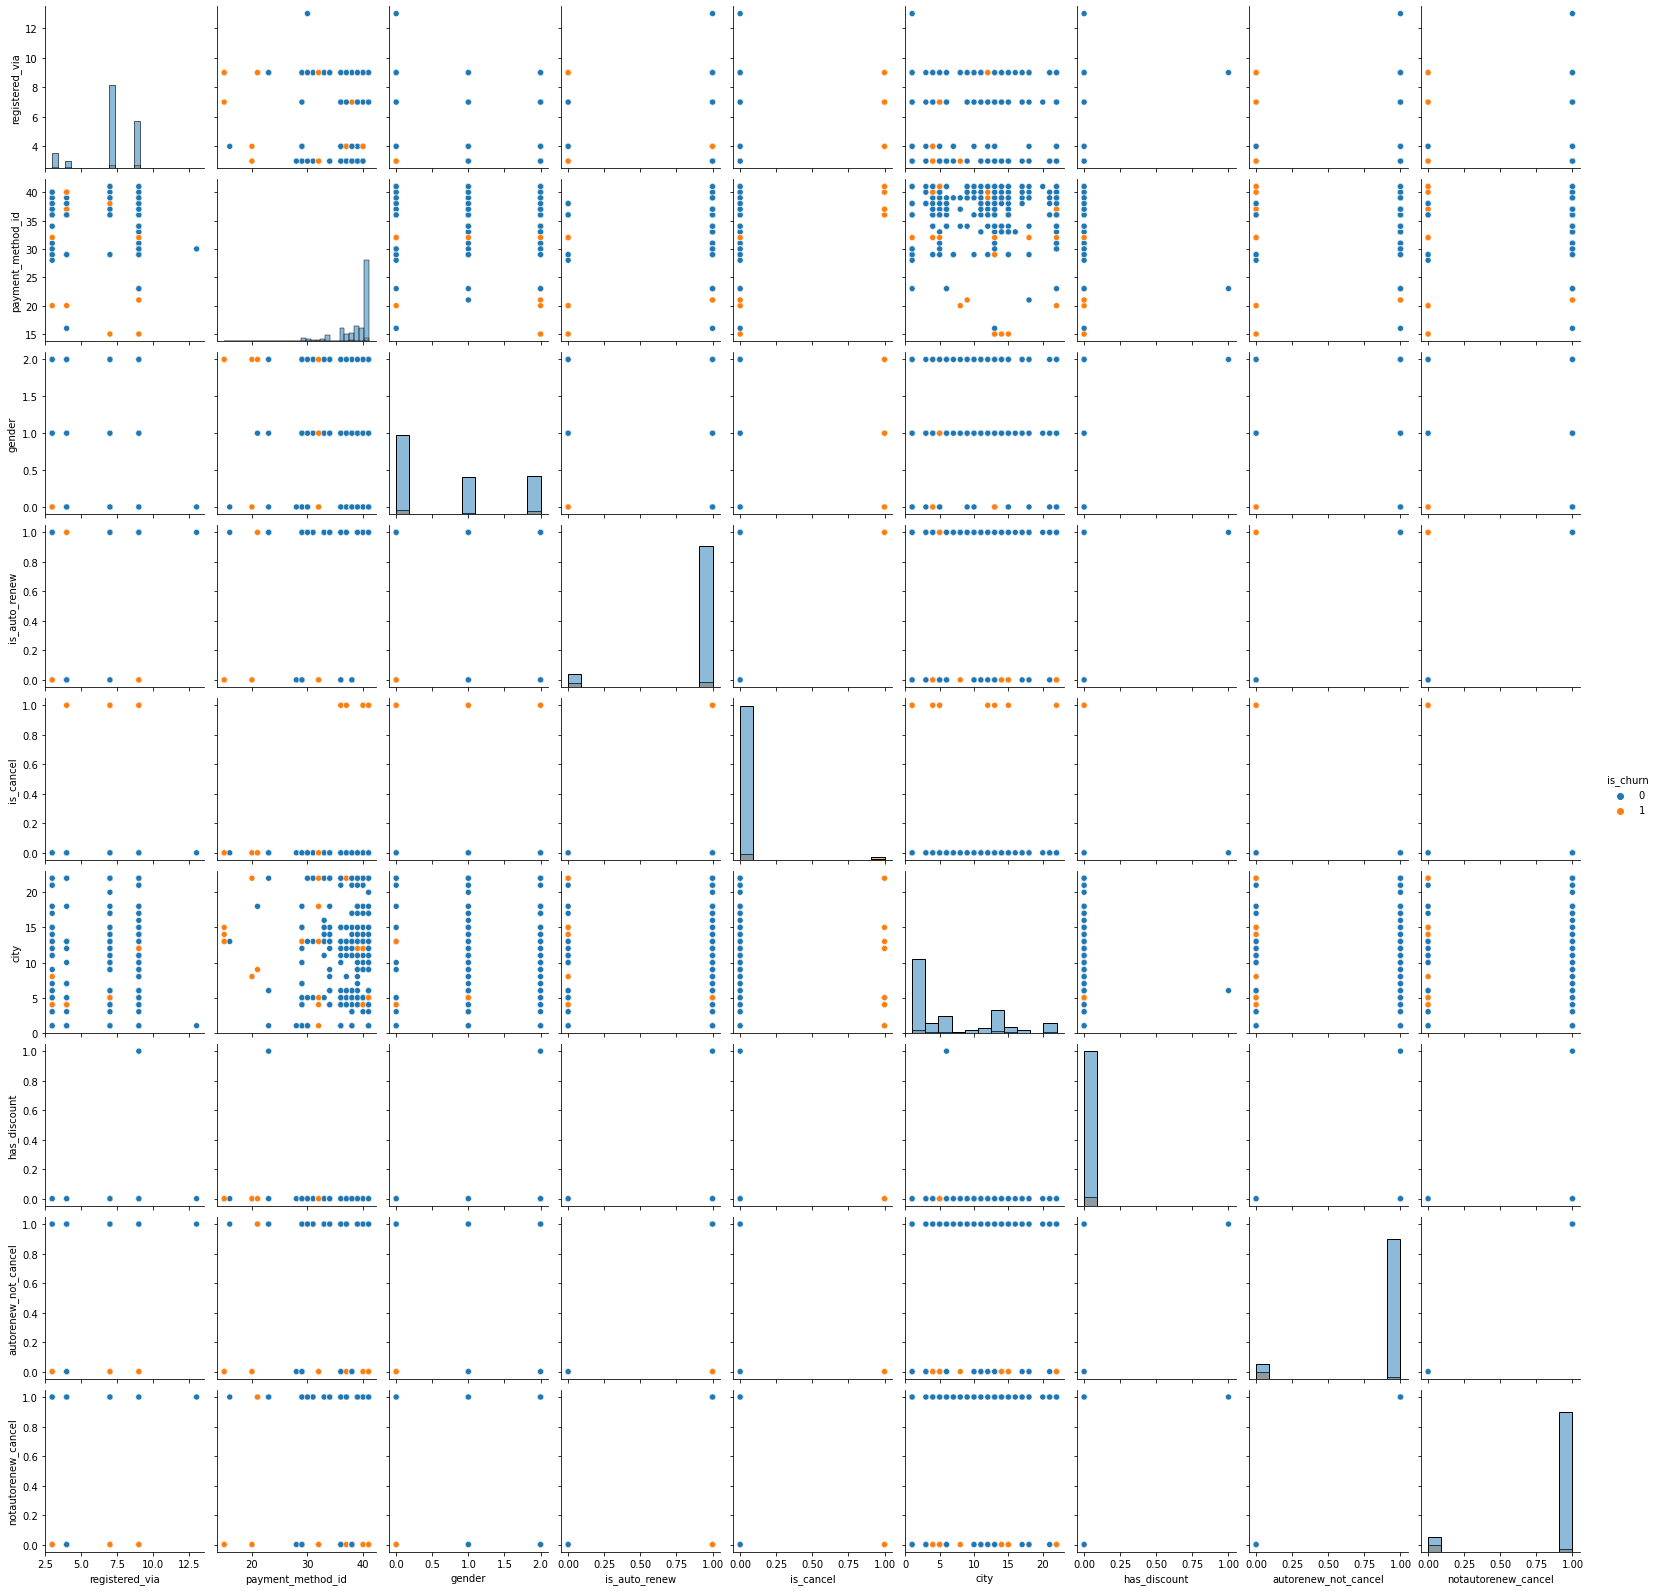

In [ ]:
disc_IVs = df[['is_churn'] + disc_vars].reset_index(drop=True)
sns.pairplot(disc_IVs.sample(frac=0.01), hue = 'is_churn', diag_kind='hist')

### Understanding the Target Variable

How many of each target class exist in the data?

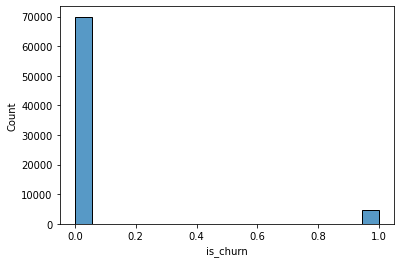

In [ ]:
sns.histplot(df['is_churn'])

What are the proportions of each class? Will need this information when building the random classifier

In [ ]:
df['is_churn'].value_counts(normalize=True)

0    0.935032
1    0.064968
Name: is_churn, dtype: float64

Target feature class balance in original data:

In [ ]:
churn_status['is_churn'].value_counts(normalize=True)

0    0.910058
1    0.089942
Name: is_churn, dtype: float64

This differs because we filtered out rows with too many missing values

### Who are the Customers?

In [ ]:
customer_info = pd.DataFrame()

customer_info['age_churn'] = pd.Series([x for x in df.age[df.is_churn.eq(1)] if x != 0]).describe()
customer_info['age_non_churn'] = pd.Series([x for x in df.age[df.is_churn.eq(0)] if x != 0]).describe()

customer_info

,age_churn,age_non_churn
count,3381.000000,33005.000000
mean,28.468500,30.329344
std,9.013893,8.930006
min,13.000000,1.000000
25%,22.000000,24.000000
50%,27.000000,29.000000
75%,33.000000,35.000000
max,98.000000,99.000000


There seems to be a mild difference in both mean and median `age` between churners and non-churners but likely insignificant. Also, there is a small imbalance in gender proportions but this could be due to sampling error since I didn't specify sampling stratification on gender:

In [ ]:
df.gender.value_counts(normalize=True)

0.0    0.509692
1.0    0.258562
2.0    0.231746
Name: gender, dtype: float64

Also from the plots above I can infer:
* Majority of customers likely live in Taipei, Taiwan
* Certain less-popular payment methods may be associated with `autorenew`, while non-churners tend to use a more popular payment method


## Transformations & Feature Reduction
<br>
Now that I have a better understanding of the data, I am ready to dive in. Given the presence of colinearity in the dataset, PCA will be performed on the continuously-valued IVs. First I will scale the data then apply PCA. Standard scaling is necessary for PCA as this technique is sensitive to different scales.

In [ ]:
cont_IVs = df.drop(columns=disc_vars)

In [ ]:
cont_IVs = cont_IVs.drop(columns=['is_churn']).reset_index(drop=True)

scaler = StandardScaler()
scaler.fit(cont_IVs)
cont_IVs = scaler.transform(cont_IVs)

Create PCA object. I don't know how many components I am looking for but I want 95% of the variance in the dataset to be captured.

In [ ]:
pca = PCA(.95, random_state=0)
pca.fit(cont_IVs)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

How many components were required to capture 95% of variance?

In [ ]:
pca.n_components_

8

How many features did we have previously?

In [88]:
cont_IVs.shape[1]

13

A 40% reduction in the total data the models need to process! What is the contribution of each principal component to the variance of the data?

In [ ]:
pca.explained_variance_ratio_

array([0.36100104, 0.22758066, 0.10771826, 0.07872002, 0.07536231,
       0.04889279, 0.04365594, 0.03731736])

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.36100104, 0.58858171, 0.69629997, 0.77501999, 0.8503823 ,
       0.89927509, 0.94293103, 0.98024839])

With 8 components I was able to capture 98% of the variance from the original dataset of 13 continuous variables

What does the Principal Components data look like?

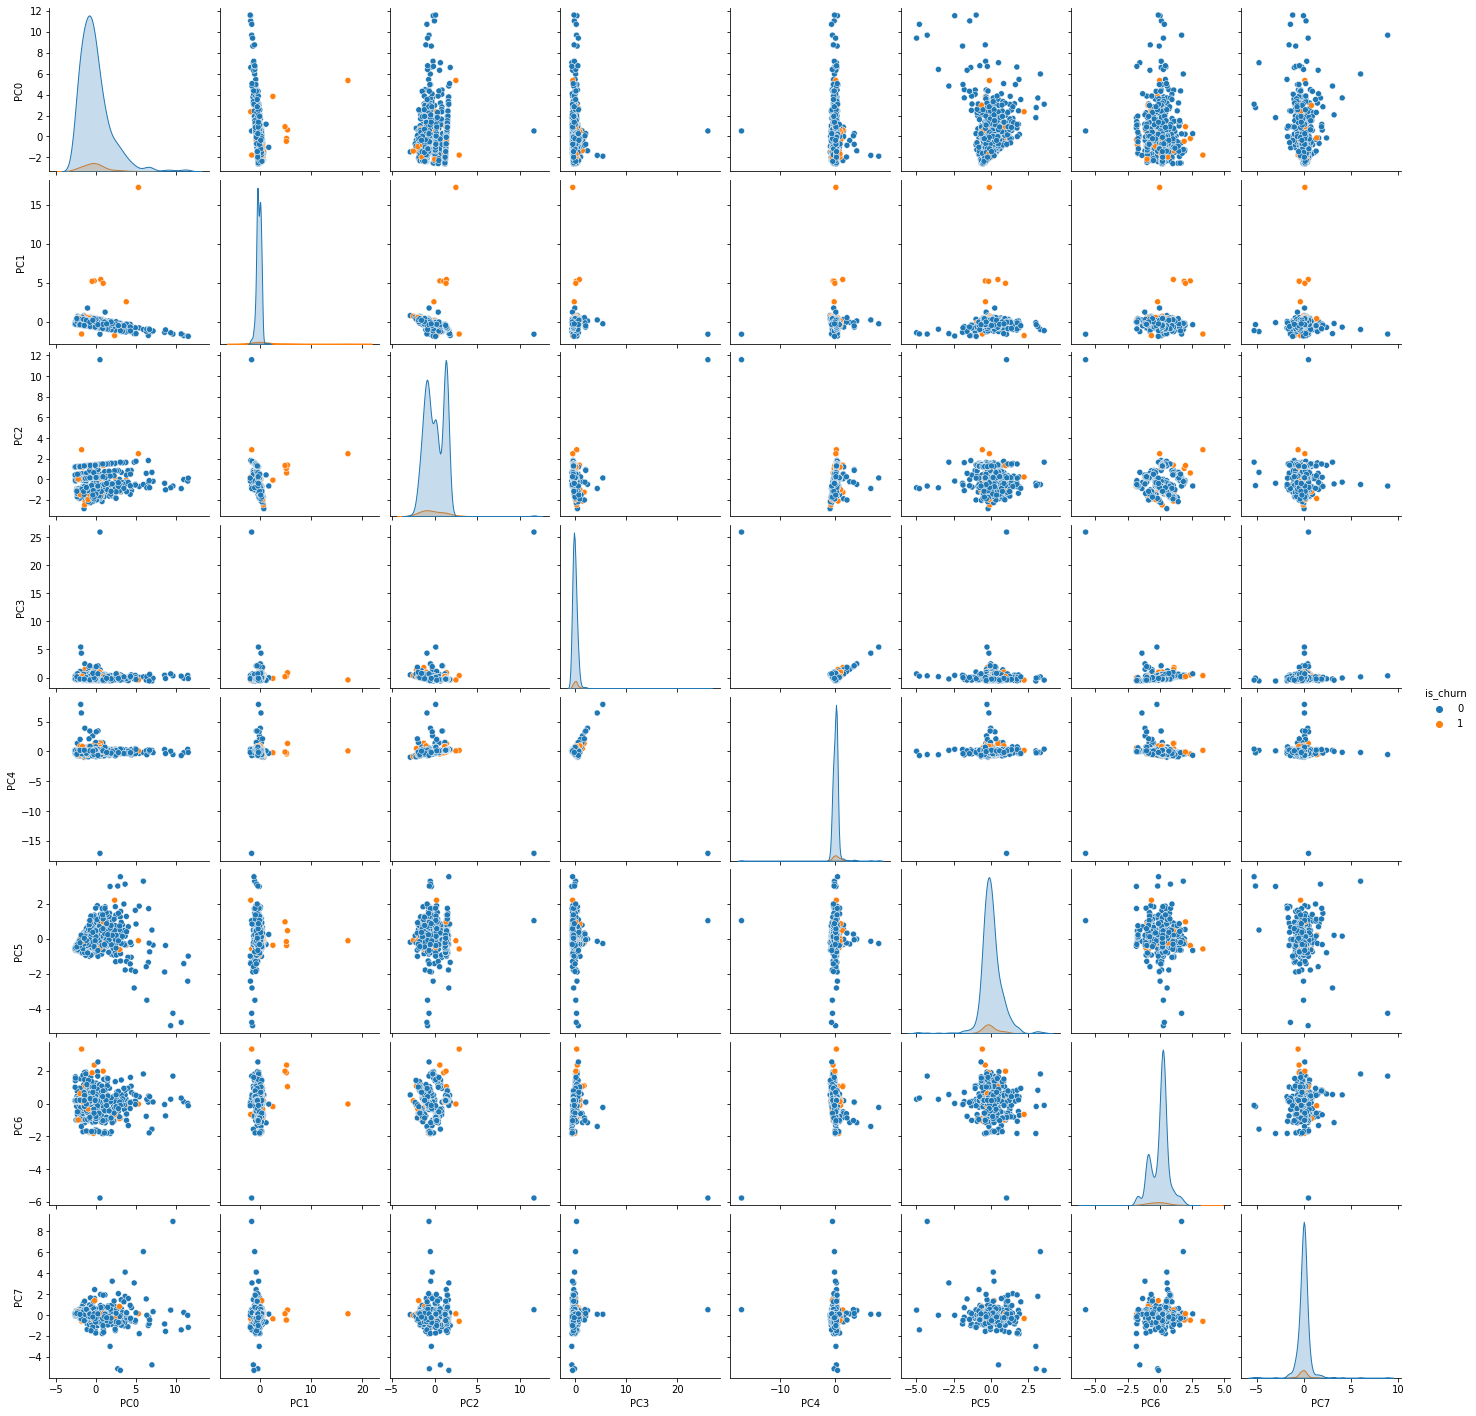

In [ ]:
principal_components = pca.transform(cont_IVs)

principal_components_df = pd.DataFrame(principal_components, columns=[f'PC{x}' for x in range(pca.n_components_)]) #seaborn pairplot needs a pandas dataframe
principal_components_df['is_churn'] = df['is_churn']
sns.pairplot(principal_components_df.sample(frac=0.01), hue='is_churn')

I now want to look at Feature Importance to determine whether or not any features can be easily excluded. To do this, I will fit a single decision tree to the data and look at the `feature_importances_` scores provided by the classifier. If any of these variables have a feature importance score of zero, they can be excluded immediately.

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
disc_IVs = disc_IVs.drop(columns=['msno', 'is_churn']) # don't want the classifier to see is_churn in the input variables
clf.fit(disc_IVs, df['is_churn']) # fit decision tree for discrete features
pd.DataFrame(zip(*[disc_IVs.columns, clf.feature_importances_]), columns = ['feature', 'score']).sort_values('score', ascending=False)

,feature,score
7,autorenew_not_cancel,0.472115
1,payment_method_id,0.328616
3,is_auto_renew,0.111523
5,city,0.042425
0,registered_via,0.020083
2,gender,0.016676
6,has_discount,0.008562
4,is_cancel,0.000000
8,notautorenew_cancel,0.000000


I am also interested in Feature Importance scores for the principal components to understand the predictive value they may hold

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(principal_components_df.drop(columns=['is_churn']), principal_components_df['is_churn']) # fit decision tree for principal components
pd.DataFrame(zip(*[principal_components_df.columns, clf.feature_importances_]), columns = ['feature', 'score']).sort_values('score', ascending=False)

,feature,score
1,PC1,0.389498
4,PC4,0.127496
7,PC7,0.091508
3,PC3,0.081048
2,PC2,0.080266
5,PC5,0.080260
6,PC6,0.078764
0,PC0,0.071160


While PC0 captures 36% of the variance in the data, it seems to be quite an unimportant feature for predicting churn status. I will check this again during model training and evaluation.

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(df.drop(columns=['is_churn', 'msno']), df['is_churn']) # fit decision tree for principal components
pd.DataFrame(zip(*[df.drop(columns=['is_churn', 'msno']).columns, clf.feature_importances_]), columns = ['feature', 'score']).sort_values('score', ascending=False)

,feature,score
5,payment_plan_days,0.326066
9,is_cancel,0.172775
10,num_transactions,0.073491
16,total_secs_sum,0.055295
14,total_secs_mean,0.054887
11,num_unq_mean,0.046947
12,num_unq_std,0.046510
15,total_secs_std,0.046506
13,num_unq_sum,0.044015
1,age,0.030155


In [ ]:
df.drop(columns=['has_discount'], inplace=True)

## Model Training & Evaluation




Now that I have more information about the data, I can make a more informed decision about which models / algorithms might be best suited for this problem. Some of the information I have gathered:
1.   Target Classes are Imbalanced 
2.   PCA Dataset -- Features are independent & normally distributed
3.   The engineered features were not very helpful
4.   PC1 data looks separable

<br>

Based on this information, and my available computing power, I will pursue an implementation of the following models:
*    Logistic Regression
*    Random Forest
*    XGBoost

<br>

To establish a baseline, I will first calculate performance metrics for the following:
*    All Zeros
*    Weighted Random Classifier

<br>

The following metrics will be used for model evaluation:

*   Accuracy -- How many were predicted correctly out of total? (TP/Total)
*   Precision -- How many were predicted correctly out of predicted positives? \[TP/(TP+FP)]
*   Recall -- How many positives were predicted correctly out of true positives? \[TP/(TP+FN)]
*   F1 -- Harmonic Mean of Precision and Recall \[2PR/(P+R)]
*   Log Loss -- Used by WSDM challenge for official scoring
*   AUC -- Area Under Curve for ROC Curve

Log Loss and AUC become necessary to include with the use of an "all-zeros" benchmark. Since no positives are predicted in an "all-zeros" model, precision, recall, and f1 cannot be calculated.


**Data Preparation**

I first need to bring the principal components and discrete IVs data together into a single dataframe

In [ ]:
data = pd.concat([principal_components_df.drop(columns=['is_churn']), disc_IVs.reset_index(drop=True)], axis=1)
data.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,registered_via,payment_method_id,gender,is_auto_renew,is_cancel,city,has_discount,autorenew_not_cancel,notautorenew_cancel
0,-1.726240,-0.414955,1.246371,-0.272185,0.181580,-0.271075,0.211672,0.035052,7.0,41.0,0.0,1.0,0.0,1.0,0,1,1
1,3.078489,-0.664816,0.395211,-0.473681,0.121389,0.459991,-0.847632,0.028869,7.0,41.0,0.0,1.0,0.0,1.0,0,1,1
2,3.240161,-0.514186,-0.494661,-0.078680,-0.269677,-0.104455,-0.042234,-0.442428,9.0,38.0,1.0,0.0,0.0,5.0,0,0,0
3,-1.792288,-0.412437,1.257106,-0.267953,0.178629,-0.376641,0.215189,0.058834,7.0,41.0,0.0,1.0,0.0,1.0,0,1,1
4,-1.367093,-0.478542,1.292192,-0.278522,0.191549,-0.198808,0.211420,-0.162544,7.0,41.0,0.0,1.0,0.0,1.0,0,1,1


The original dataset for reference:

In [ ]:
df.head()

,msno,is_churn,city,age,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_transactions,num_unq_mean,num_unq_std,num_unq_sum,total_secs_mean,total_secs_std,total_secs_sum,discount_amount,daily_charge,autorenew_not_cancel,notautorenew_cancel
0,HswNTXYn4yqi+SBF/+CEXLFMsMY782zPuZrSbp9rnXU=,0,1.0,0.0,0.0,7.0,41.0,30.0,100.0,100.0,1.0,0.0,1.0,13.500000,6.595453,81.0,3257.179667,1573.402852,19543.078,0.0,3.333333,1,1
1,YpV73qpyuBf0hE297bPrJC5ReGFAggVlRAhkdmkosXg=,0,1.0,0.0,0.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,1.0,48.840000,37.209631,1221.0,14311.786320,9877.770169,357794.658,0.0,4.966667,1,1
2,5xMdelsM6lD/cjJV68fPwY204ex4/PMyhOp+cw1fuio=,0,5.0,23.0,1.0,9.0,38.0,30.0,149.0,149.0,0.0,0.0,1.0,51.193548,34.545062,1587.0,12388.903387,8911.757318,384056.005,0.0,4.966667,0,0
3,yLy69CnA2ii5ASjdRmAdy3kxzm2vUQ5XlRPbvgIHLSg=,0,1.0,0.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,1.0,8.375000,5.976858,201.0,1965.923792,1604.436391,47182.171,0.0,3.300000,1,1
4,xM2rRflI17cwH60+jpwDoWKzM+ng6zpMKVrLVfG06DQ=,0,1.0,0.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,1.0,14.315789,10.990160,272.0,2776.411526,2100.921241,52751.819,0.0,3.300000,1,1


### Splitting the data

Using 80/20 split. I am interested in fitting models to both the `pca` dataset and the `base` dataset so train/test sets need to be created for both.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    principal_components_df['is_churn'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=principal_components_df['is_churn'])

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df.drop(columns=['msno', 'is_churn']), 
                                                                        df['is_churn'], 
                                                                        test_size=0.2, 
                                                                        random_state=42, 
                                                                        stratify=df['is_churn'])

Is everything still balanced?

In [ ]:
y_train.value_counts(normalize=True)

0    0.935031
1    0.064969
Name: is_churn, dtype: float64

In [92]:
list(y_test.value_counts(normalize=True))

[0.9350354230717819, 0.06496457692821815]

### All Zeros 

Evaluation results for predicting 0 or no churn for all customers

In [ ]:
pred_results = dict() #store output prediction results

pred_results['all_zeros'] = [0]*len(y_test)
all_zeros = eval_metrics(y_test, pred_results['all_zeros'], 'All Zeros')
all_zeros

,accuracy,precision,recall,f1,auc,log loss
All Zeros,0.935035,0.0,0.0,0.0,0.5,2.243797


### Random Classifier

Evaluation results for randomly deciding whether or not a customer would churn, weighted by class balance:

In [89]:
pred_results['random'] = np.random.choice([0, 1], len(y_test), p=[0.935, 0.065]) #list(y_test.value_counts(normalize=True))
random_classifier = eval_metrics(y_test, pred_results['random'], 'Random Classifier')
random_classifier

,accuracy,precision,recall,f1,auc,log loss
Random Classifier,0.879829,0.059701,0.057613,0.058639,0.497284,4.15061


### Logistic Regression

Although the `base` dataset does not meet the assumptions required for logistic regression, I am fitting the model to obtain a baseline set of metrics

In [ ]:
logisticRegr = LogisticRegression(solver = 'lbfgs')

logisticRegr.fit(X_train_base, y_train)
pred_results['base_log_reg'] = logisticRegr.predict(X_test_base)

base_log_reg = eval_metrics(y_test, pred_results['base_log_reg'], 'BASE_LOG_REG')
base_log_reg

,accuracy,precision,recall,f1,auc,log loss
BASE_LOG_REG,0.955554,0.987302,0.319959,0.483294,0.659836,1.535108


The `pca` dataset **does** uphold the assumptions held by the logistic regression model and, as a result, performs much better than on the `base` dataset:

In [ ]:
train = X_train.drop(columns=['has_discount', 'autorenew_not_cancel', 'notautorenew_cancel'])

log_reg = sm.Logit(y_train, train).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.122967
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_churn   No. Observations:                59844
Model:                          Logit   Df Residuals:                    59830
Method:                           MLE   Df Model:                           13
Date:                Tue, 09 Mar 2021   Pseudo R-squ.:                  0.4885
Time:                        01:08:48   Log-Likelihood:                -7358.8
converged:                       True   LL-Null:                       -14388.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
PC0                   0.1196      0.014      8.813      0.000       0.093       0.146
PC1                   1.1287      0.051     22.169      0.000       1.029       1.229
PC2                   0.2731      0.030      9.005      0.000       0.214       0.333
PC3                   0.2835      0.015     18.678      0.000       0.254       0.313
PC4                   0.1364      0.016      8.778      0.000       0.106       0.167
PC5                  -0.0454      0.031     -1.472      0.141      -0.106       0.015
PC6                   0.2377      0.034      6.981      0.000       0.171       0.304
PC7                  -0.0329      0.034     -0.963      0.335      -0.100       0.034
registered_via       -0.0429      0.010     -4.256      0.000      -0.063      -0.023
payment_method_id    -0.0405      0.002    -18.076      0.000      -0.045      -0.036
gender                0.0938      0.044      2.125      0.034       0.007       0.180
is_auto_renew        -2.0719      0.062    -33.521      0.000      -2.193      -1.951
is_cancel             4.9670      0.073     68.429      0.000       4.825       5.109
city                  0.0041      0.004      0.947      0.344      -0.004       0.012
=====================================================================================
"""

In [ ]:
print(adjusted_r2(log_reg, train))

Adjusted R^2: 0.48843


I will attempt to remove the features that the Logistic Regression model finds insignificant and fit again to see if adjusted R^2 improves:

In [ ]:
train = X_train.drop(columns=['has_discount', 'autorenew_not_cancel', 'notautorenew_cancel', 'PC5', 'PC7', 'city'])
test = X_test.drop(columns=['has_discount', 'autorenew_not_cancel', 'notautorenew_cancel', 'PC5', 'PC7', 'city'])


log_reg = sm.Logit(y_train, train).fit()
pred_results['pca_log_reg'] = np.asarray([np.round(line) for line in log_reg.predict(test)])

log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.123002
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_churn   No. Observations:                59844
Model:                          Logit   Df Residuals:                    59833
Method:                           MLE   Df Model:                           10
Date:                Tue, 09 Mar 2021   Pseudo R-squ.:                  0.4884
Time:                        01:14:45   Log-Likelihood:                -7360.9
converged:                       True   LL-Null:                       -14388.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
PC0                   0.1194      0.013      8.869      0.000       0.093       0.146
PC1                   1.1295      0.051     22.310      0.000       1.030       1.229
PC2                   0.2692      0.029      9.148      0.000       0.212       0.327
PC3                   0.2838      0.015     19.120      0.000       0.255       0.313
PC4                   0.1359      0.015      8.973      0.000       0.106       0.166
PC6                   0.2398      0.034      7.146      0.000       0.174       0.306
registered_via       -0.0418      0.010     -4.159      0.000      -0.062      -0.022
payment_method_id    -0.0403      0.002    -18.474      0.000      -0.045      -0.036
gender                0.1110      0.043      2.609      0.009       0.028       0.194
is_auto_renew        -2.0713      0.062    -33.496      0.000      -2.192      -1.950
is_cancel             4.9608      0.072     68.451      0.000       4.819       5.103
=====================================================================================
"""

In [ ]:
print(adjusted_r2(log_reg, train))

Adjusted R^2: 0.48831


Improvement not seen when removing 'insignificant' features from this logistic regression model.

In [ ]:
pca_log_reg = eval_metrics(y_test, pred_results['pca_log_reg'], 'PCA_LOG_REG')
pca_log_reg

,accuracy,precision,recall,f1,auc,log loss
PCA_LOG_REG,0.966849,0.838068,0.606996,0.704057,0.799424,1.144989


Overall model development seems to be moving in the right direction

### Random Forest Model

The random forest model is a good choice as it is robust when dealing with imbalanced classes. It is also not sensitive to scale so it can be used to fit the `base` dataset

In [ ]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf.fit(X_train_base, y_train_base)
pred_results['base_rf'] = rf.predict(X_test_base)

base_rf = eval_metrics(y_test, pred_results['base_rf'], 'Base_RF')
base_rf

,accuracy,precision,recall,f1,auc,log loss
Base_RF,0.973332,0.900699,0.662551,0.763485,0.828738,0.921069


In [ ]:
pd.DataFrame(zip(*[X_train_base.columns, rf.feature_importances_]), columns = ['feature', 'score']).sort_values('score', ascending=False)

,feature,score
6,plan_list_price,0.103404
7,actual_amount_paid,0.097523
5,payment_plan_days,0.090774
9,is_cancel,0.083099
10,num_transactions,0.082196
16,total_secs_sum,0.054252
13,num_unq_sum,0.051188
19,autorenew_not_cancel,0.050198
15,total_secs_std,0.049220
14,total_secs_mean,0.049031


Now random forest model with PCA dataset:

In [ ]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
pred_results['pca_rf'] = rf.predict(X_test)

pca_rf = eval_metrics(y_test, pred_results['pca_rf'], 'PCA_RF')
pca_rf

,accuracy,precision,recall,f1,auc,log loss
PCA_RF,0.972063,0.876359,0.66358,0.755269,0.828538,0.96493


In [ ]:
pd.DataFrame(zip(*[X_train.columns, rf.feature_importances_]), columns = ['feature', 'score']).sort_values('score', ascending=False)

,feature,score
1,PC1,0.207456
4,PC4,0.095255
2,PC2,0.094549
3,PC3,0.076749
15,autorenew_not_cancel,0.074416
12,is_cancel,0.072632
16,notautorenew_cancel,0.068339
6,PC6,0.064407
0,PC0,0.050215
5,PC5,0.044062


### XGBoost

Given the strong performance of the random forest model, I decided to implement XGBoost (a popular choice in recent years due to its efficiency and robustness).

In [ ]:
xgb_data = dict()

xgb_data['pca_train'] = xgb.DMatrix(X_train, label=y_train)
xgb_data['pca_test'] = xgb.DMatrix(X_test, label=y_test)

xgb_data['base_train'] = xgb.DMatrix(X_train_base, label=y_train_base)
xgb_data['base_test'] = xgb.DMatrix(X_test_base, label=y_test_base)

In [ ]:
param = {
    'eta': 0.3,  # the training step for each iteration / learning rate
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2, # the number of classes that exist in this dataset
    'seed': 0
}  
num_round = 20  # the number of training iterations

In [ ]:
def train_xgboost(hyperparameters, xgb_data):
  param, num_round = hyperparameters
  pred_results = dict()

  for dataset in ['pca', 'base']:
    xgb_model = xgb.train(param, xgb_data[f'{dataset}_train'], num_round) #train xgb on pca data
    pred_results[f'{dataset}_xgb'] = xgb_model.predict(xgb_data[f'{dataset}_test'])
    pred_results[f'{dataset}_xgb'] = np.asarray([np.argmax(line) for line in pred_results[f'{dataset}_xgb']]) #convert probabilities to classes

  return pred_results

In [ ]:
results = train_xgboost((param, num_round), xgb_data)
for k in results.keys():
  pred_results[k] = results[k]

In [ ]:
pca_xgb = eval_metrics(y_test, pred_results['pca_xgb'], 'PCA_XGB')
pca_xgb

,accuracy,precision,recall,f1,auc,log loss
PCA_XGB,0.972196,0.875676,0.666667,0.757009,0.830045,0.960313


In [ ]:
base_xgb = eval_metrics(y_test, pred_results['base_xgb'], 'BASE_XGB')
base_xgb

,accuracy,precision,recall,f1,auc,log loss
BASE_XGB,0.972397,0.893108,0.653292,0.754605,0.82393,0.953387


### Basic Hyperparameter Tuning

There are more sophisticated ways of doing this, such as using GridSearchCV, but for simplicity and resource constraints I am only looking into a few values of `eta` and `num_round`

In [ ]:
tuning_df = pd.DataFrame()

eta_vals = [x/100 for x in range(28, 32, 1)]
num_iters = list(range(17, 22, 1))

for eta in eta_vals:
  for rounds in num_iters:
    pred = train_xgboost(({'eta': eta, 'silent': 1, 'objective': 'multi:softprob', 'num_class': 2, 'seed': 0}, rounds), xgb_data)
    
    for dataset in ['pca', 'base']:
      opt_results = eval_metrics(y_test, pred[f'{dataset}_xgb'], f'{dataset}_XGB_{eta}_{rounds}'.upper())
      opt_results['eta'] = eta
      opt_results['rounds'] = rounds
      opt_results['dataset'] = dataset
      
      tuning_df = pd.concat([tuning_df, opt_results], axis=0)

tuning_df.sort_values('log loss')

,accuracy,precision,recall,f1,auc,log loss,eta,rounds,dataset
BASE_XGB_0.31_21,0.973399,0.896409,0.667695,0.765330,0.831167,0.918760,0.31,21,base
BASE_XGB_0.31_17,0.973332,0.898470,0.664609,0.764045,0.829696,0.921069,0.31,17,base
BASE_XGB_0.31_20,0.973332,0.895172,0.667695,0.764879,0.831132,0.921069,0.31,20,base
BASE_XGB_0.31_19,0.973332,0.895172,0.667695,0.764879,0.831132,0.921069,0.31,19,base
BASE_XGB_0.31_18,0.973266,0.897222,0.664609,0.763593,0.829660,0.923377,0.31,18,base
BASE_XGB_0.28_20,0.973199,0.899301,0.661523,0.762300,0.828188,0.925686,0.28,20,base
BASE_XGB_0.28_21,0.973132,0.896936,0.662551,0.762130,0.828631,0.927994,0.28,21,base
BASE_XGB_0.28_18,0.973065,0.899018,0.659465,0.760831,0.827159,0.930302,0.28,18,base
BASE_XGB_0.29_20,0.973065,0.894591,0.663580,0.761961,0.829074,0.930303,0.29,20,base
BASE_XGB_0.29_21,0.973065,0.894591,0.663580,0.761961,0.829074,0.930303,0.29,21,base


The top 5 ranking models all used the `base` dataset with learning rate = 0.31 Fit XGBoost with optimized values of eta (learning rate) and iterations:

In [ ]:
param = {
    'eta': tuning_df.loc[tuning_df['log loss'].idxmin(), 'eta'],  # optimized eta value
    'silent': 1,
    'objective': 'multi:softprob',
    'num_class': 2, 
    'seed': 0
}

num_round = tuning_df.loc[tuning_df['log loss'].idxmin(), 'rounds']  #optimized number of rounds

xgb_model = xgb.train(param, xgb_data['pca_train'], num_round) #train xgb on pca data
pred_results['pca_xgb_optimized'] = xgb_model.predict(xgb_data['pca_test'])
pred_results['pca_xgb_optimized'] = np.asarray([np.argmax(line) for line in pred_results['pca_xgb_optimized']]) #convert probabilities to classes

xgb_model_base = xgb.train(param, xgb_data['base_train'], num_round) #train xgb on base data
pred_results['base_xgb_optimized'] = xgb_model_base.predict(xgb_data['base_test'])  
pred_results['base_xgb_optimized'] = np.asarray([np.argmax(line) for line in pred_results['base_xgb_optimized']])

pca_xgb_optimized  = eval_metrics(y_test, pred_results['pca_xgb_optimized'],  'PCA_XGB_OPT')
base_xgb_optimized = eval_metrics(y_test, pred_results['base_xgb_optimized'], 'BASE_XGB_OPT')

In [ ]:
pca_xgb_optimized

,accuracy,precision,recall,f1,auc,log loss
PCA_XGB_OPT,0.972397,0.884457,0.661523,0.756916,0.827759,0.953387


In [ ]:
base_xgb_optimized

,accuracy,precision,recall,f1,auc,log loss
BASE_XGB_OPT,0.973399,0.896409,0.667695,0.76533,0.831167,0.91876


What did XGBoost find important?

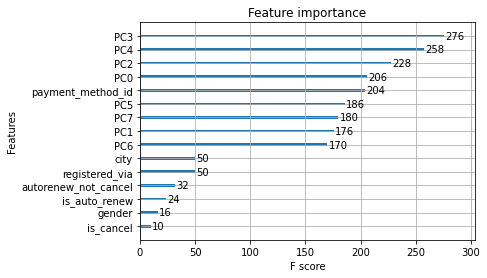

In [ ]:
xgb.plot_importance(xgb_model) #pca data

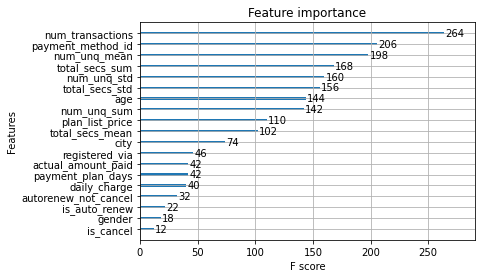

In [ ]:
xgb.plot_importance(xgb_model_base) #base data

### Evaluation Metrics Summary

The max value of each metric is highlighted below to indicate the best performing algorithm. Since I am using highlight_max, I will sort the dataframe 
by `log loss` to keep the minimum (best) value in the first row.

In [ ]:
eval_df = pd.concat([all_zeros, 
                     random_classifier, 
                     base_rf, 
                     base_xgb, 
                     pca_log_reg, 
                     pca_rf, 
                     pca_xgb, 
                     pca_xgb_optimized, 
                     base_xgb_optimized], 
                    axis=0)

eval_df.sort_values('log loss').style.highlight_max(color = 'lightgreen', axis = 0)
#eval_df.sort_values('auc', ascending=False)

,accuracy,precision,recall,f1,auc,log loss
BASE_XGB_OPT,0.973399,0.896409,0.667695,0.765330,0.831167,0.918760
Base_RF,0.973332,0.900699,0.662551,0.763485,0.828738,0.921069
BASE_XGB,0.972397,0.893108,0.653292,0.754605,0.823930,0.953387
PCA_XGB_OPT,0.972397,0.884457,0.661523,0.756916,0.827759,0.953387
PCA_XGB,0.972196,0.875676,0.666667,0.757009,0.830045,0.960313
PCA_RF,0.972063,0.876359,0.663580,0.755269,0.828538,0.964930
PCA_LOG_REG,0.966849,0.838068,0.606996,0.704057,0.799424,1.144989
All Zeros,0.935035,0.000000,0.000000,0.000000,0.500000,2.243797
Random Classifier,0.859979,0.077502,0.105967,0.089526,0.509167,4.836233


The tuned XGBoost model fitted to the `base` dataset achieved the best performance in five of the six metrics collected: accuracy, recall, F1, auc, and log loss; however, the untuned random forest model fitted to the `base` dataset was the highest ranking model for precision (sensitivity)

### Confusion Matrix Plots

Model with best accuracy, precision, and log loss scores:

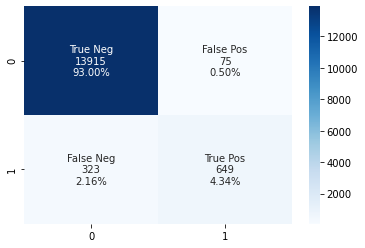

In [ ]:
cm_plot(y_test, pred_results['base_xgb_optimized'])

Model with worst scores:

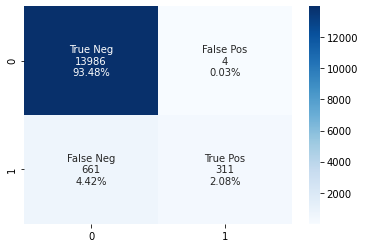

In [ ]:
cm_plot(y_test, pred_results['base_log_reg'])

Model with best precision:

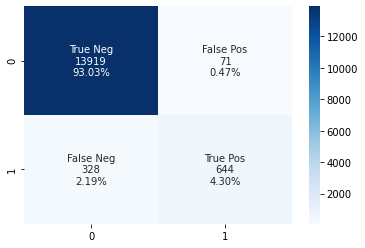

In [93]:
cm_plot(y_test, pred_results['base_rf'])

Random Classifier:

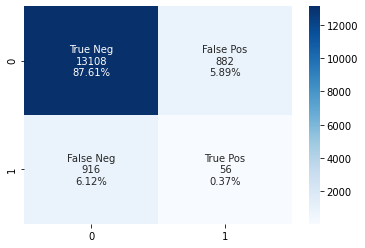

In [94]:
cm_plot(y_test, pred_results['random'])

## Limitations of Current Work & Future Directions








*   Computational Resources
    * Colab will terminate processes that run for more than a few minutes
    * Certain models, namely SVM, were not pursued for performance reasons
*   Dataset Size
    * The original dataset consisted of ~50M rows; approximately 75K were used here
*   Temporal Re-factoring / Feature Engineering (Trend-focused)
    * week over week change % in usage duration and number of songs
*   Class Rebalancing / Oversampling / Data Augmentation
    * e.g. SMOTE, Imputing missing values
        * Less than 0.2% of the entire dataset was used for this project. Would greater benefit be achived by rebalancing the data used with more "fake" data, or by simply using more of the data available? 
*   Implement Cross Validation
    * The above question may apply here too
*   Further Hyperparameter Tuning on Models
    * If we determine recall is important, we can tune a model to maximize that metric with GridSearchCV
*   Deep Learning & Sequence-based Models
    * e.g. LSTM, but model complexity needs to be balanced with resources and cost
*   The window of data used here would be too tight for real intervention
*   More detailed data cleaning and validation
    * Outliers, instances where subscription expiration occurs before registration

## Conclusions & Discussion

The goals of the project will be reviewed and evaluated here:

**Goal #1:** Build a model to predict customer churn with better performance than a random or all-zeros classifier
*    The tuned XGBoost implementation fitted on the `base` dataset performed much better than baseline and achieved a log loss of 0.929 and AUC score of 0.828. This was better performance than the tested Logistic Regression, and Random Forest models fitted to either the `base` or `pca` datasets

**Goal #2:** Identify primary drivers of churn
*    There was a general sense of agreement among the various models for these common highly-scored features:
    * number of payments
    * number of unique songs played
    * variance in unique songs per day over tenure

**Goal #3:** Acquire a basic understanding of KKBox's customer base 
*    Users are concentrated in one city (likely Taipei, Taiwan) and have a median age around 27 years old. There seems to be no significant effect on churn status by either gender or age, as determined by the trained models. XGBoost ranked payment method highly -- this could mean that users who do not use a popular payment choice are more likely to churn.


#### Why did XGBoost achieve the best performance?

*   Has the ability to "learn" and correct mistakes made by previous trees (uses gradient descent)
*   Built-in regularization / tree pruning helps prevent overfitting

<br>

#### Why did the `base` dataset achieve better performance than the `pca` dataset?

My theory is that, in this case, retaining information (avoiding PCA) gives the model better insight into customer activity. In addition, it may suggest that having more features might be better at informing the model. This would highlight the importance of data modeling and feature engineering in customer churn problems.



**Given that all goals for this project were met, despite this project's limitations I consider it a successful proof-of-concept for using user activity and similar attributes to predict churn status.**